In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import skewnorm
from scipy.special import erf
import matplotlib.pyplot as plt
from tqdm import tqdm
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

data = np.load('./data/70o3aeventPE.npz', allow_pickle=True)

In [2]:
m1 = data['m1']
q = data['q']
snr = data['snr']
mz = data['mz']
chi_p = data['chi_p']
chi_eff = data['chi_eff']
a_1 = data['a_1']
a_2 = data['a_2']


snr_median = np.array([np.median(s) for s in snr])
q_median = np.array([np.median(qi) for qi in q])
m1_median = np.array([np.median(mi) for mi in m1])
chip_median = np.array([np.median(ci) for ci in chi_p])
chieff_median = np.array([np.median(ci) for ci in chi_eff])
a1_median = np.array([np.median(ai) for ai in a_1])
a2_median = np.array([np.median(ai) for ai in a_2])



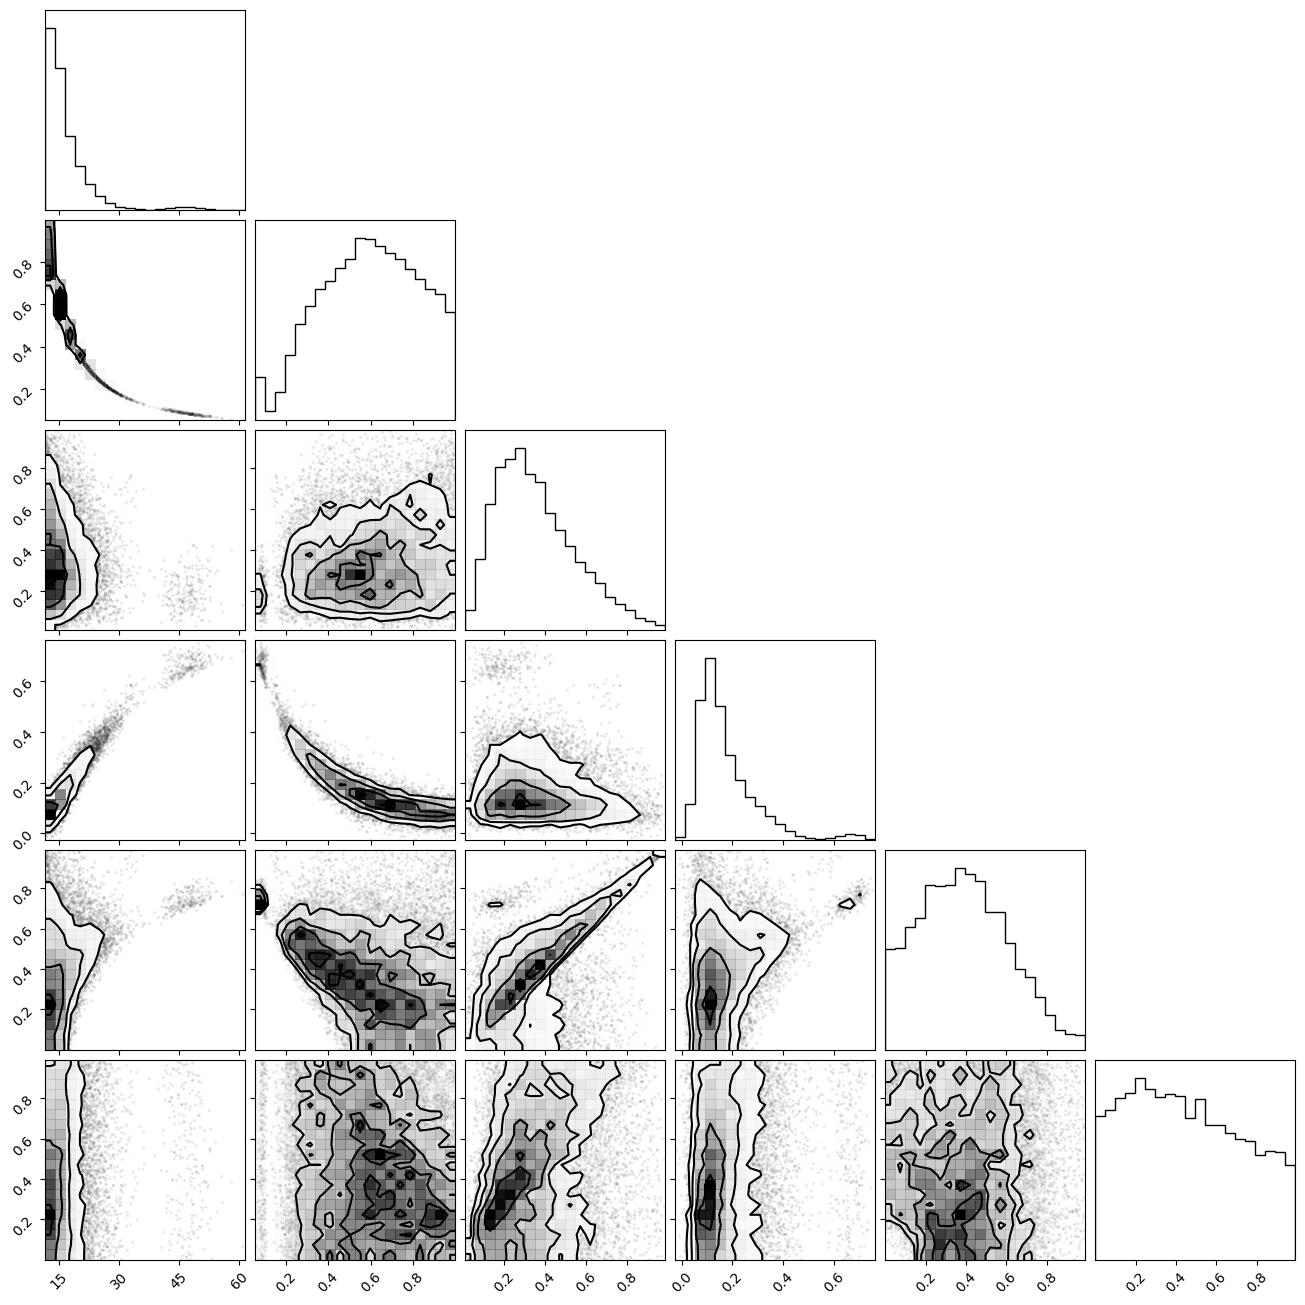

In [3]:
import corner.corner as cc
for i in range(1):
    s = np.array([m1[i], q[i], chi_p[i], chi_eff[i], a_1[i], a_2[i]]).T
    fig = cc(s)

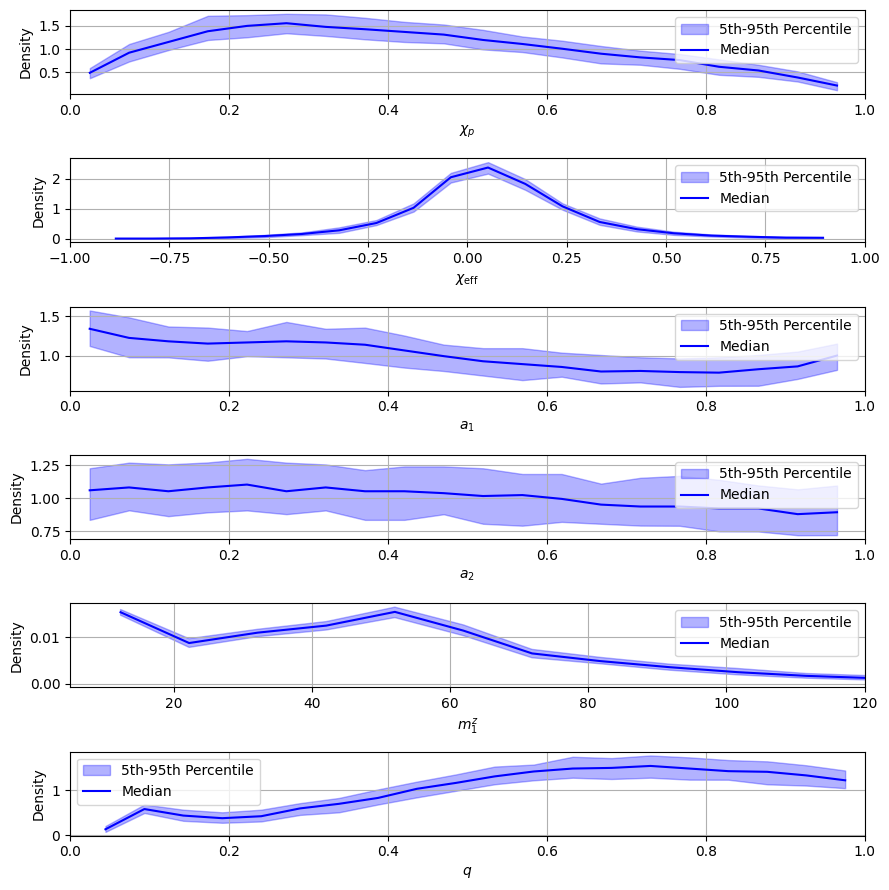

In [4]:
# Function to compute percentiles
def compute_percentiles(data, percentiles):
    return np.percentile(data, percentiles, axis=0)

# Function to draw samples and calculate percentiles
def analyze_spin_data(posterior_data, repetitions, bins, percentiles=(5, 50, 95)):
    bin_edges = np.linspace(np.min([min(p) for p in posterior_data]), np.max([max(p) for p in posterior_data]), bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    histograms = []
    for _ in range(repetitions):
        samples = [np.random.choice(event_posterior, size=20) for event_posterior in posterior_data]
        combined_samples = np.concatenate(samples)
        hist, _ = np.histogram(combined_samples, bins=bin_edges, density=True)
        histograms.append(hist)

    histograms = np.array(histograms)
    percentiles_result = compute_percentiles(histograms, percentiles)
    return bin_centers, percentiles_result

# Analyze and plot
def plot_with_percentiles(ax, posterior_data, label, bins=20, xlim=[0,1]):
    bin_centers, percentiles_result = analyze_spin_data(posterior_data, n_repetitions, bins)

    ax.fill_between(bin_centers, percentiles_result[0], percentiles_result[2], alpha=0.3, color="blue", label="5th-95th Percentile")
    ax.plot(bin_centers, percentiles_result[1], color="blue", label="Median")
    ax.set_xlabel(label)
    ax.set_ylabel("Density")
    ax.set_xlim(xlim[0], xlim[1])
    ax.legend()
    ax.grid()
    #plt.show()

    
n_repetitions = 100
# Plotting for chi_p, chi_eff, etc.
fig, ax = plt.subplots(6, 1, figsize=(9, 9))
plot_with_percentiles(ax[0], chi_p, r"$\chi_p$")
plot_with_percentiles(ax[1], chi_eff, r"$\chi_\mathrm{eff}$", xlim=[-1,1])
plot_with_percentiles(ax[2], a_1, r"$a_1$")
plot_with_percentiles(ax[3], a_2, r"$a_2$")
plot_with_percentiles(ax[4], m1, r"$m_1^z$", bins=100, xlim=[5,120])
plot_with_percentiles(ax[5], q, r"$q$")

fig.tight_layout()

In [5]:

# Skew-normal PDF with loc computed from x_max
def skew_normal_pdf(x, x_max, sigma, alpha):
    # Calculate loc from the mode x_max
    delta = alpha / np.sqrt(1 + alpha**2)
    loc = x_max - sigma * delta
    
    # PDF of skew-normal distribution
    z = (x - loc) / sigma
    phi = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * z**2)  # Normal PDF
    Phi = 0.5 * (1 + erf(alpha * z / np.sqrt(2)))  # CDF of the skew-normal
    
    return 2 / sigma * phi * Phi

# Log-likelihood function for the given data and skew-normal parameters
def log_likelihood(params, data):
    x_max, sigma, alpha = params
    pdf_vals = skew_normal_pdf(data, x_max, sigma, alpha)
    
    # Avoid log(0) issues by adding a small epsilon to pdf_vals
    return -np.sum(np.log(pdf_vals + 1e-10))  # Minimize negative log-likelihood


def compute_loc_from_mode(x_max, alpha, scale):
    # Calculate delta (skewness-related term)
    delta = alpha / np.sqrt(1 + alpha**2)
    
    # Calculate loc (xi) using the mode
    loc = x_max - scale * delta
    return loc

def truncated_skewnorm(alpha, scale, x_max, lower_bound, upper_bound, size=1000):
    # Compute loc from the provided x_max
    loc = compute_loc_from_mode(x_max, alpha, scale)
    
    samples = []
    while len(samples) < size:
        # Generate samples from skew-normal with computed loc
        sample = skewnorm.rvs(alpha, loc=loc, scale=scale)
        
        # Accept the sample if it falls within the bounds
        if lower_bound <= sample <= upper_bound:
            samples.append(sample)
    
    return np.array(samples)



In [6]:
# Example: Replace this with your actual data
x_max_fitted, sigma_fitted, alpha_fitted = [], [], [] 
for i in range(q.size):
    data = q[i][:5000]

    # Initial guesses for x_max, sigma, and alpha
    initial_params = [0.0, 1.0, 0.0]  # Initial guess: [x_max, scale (sigma), skew (alpha)]

    # Define bounds for the parameters
    bounds = [(-np.inf,np.inf), (1e-5, np.inf), (-10,10)]  # Example bounds for the parameters

    # Optimize the log-likelihood to find the best-fit parameters
    result = minimize(log_likelihood, initial_params, args=(data,), method='L-BFGS-B', bounds=bounds)

    # Extract the fitted parameters
    _x_max_fitted, _sigma_fitted, _alpha_fitted = result.x
    x_max_fitted.append(_x_max_fitted)
    sigma_fitted.append(_sigma_fitted)
    alpha_fitted.append(_alpha_fitted)
    

100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


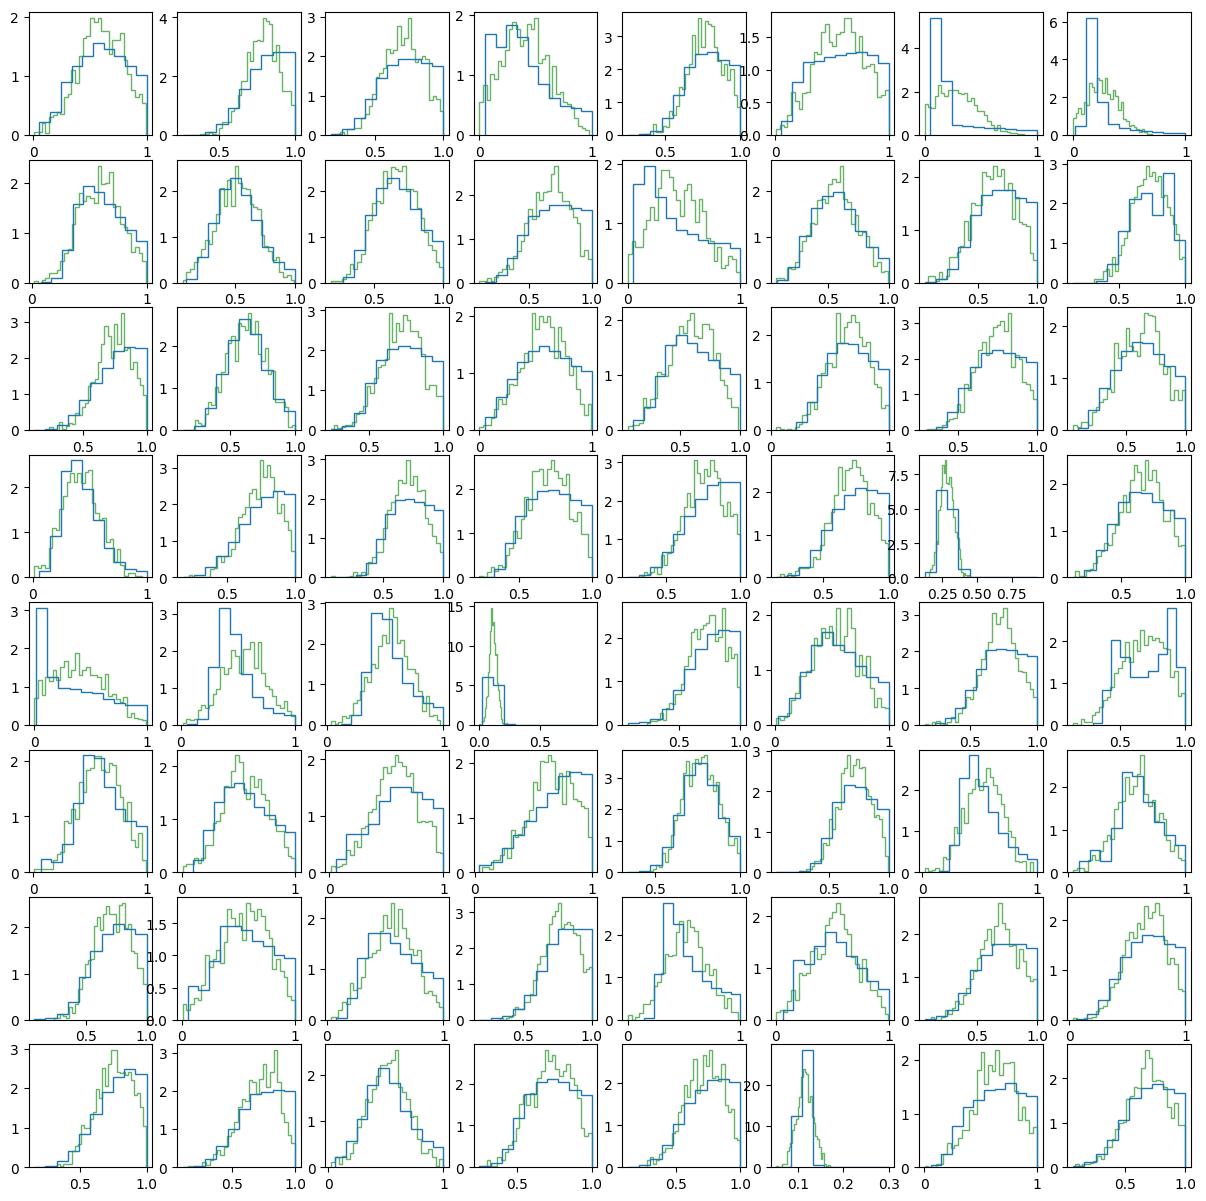

In [7]:
nrow = 8
ncol = 8
fig, ax = plt.subplots(nrow, ncol, figsize=(15,15))
for i in tqdm(range(nrow)):
    for j in range(ncol):
        idx = i * nrow + j
        # Parameters for the skew-normal distribution
        alpha = alpha_fitted[idx]  # Shape parameter (controls skewness)
        loc = x_max_fitted[idx]  # Location parameter (mean-like, center of the distribution)
        scale = sigma_fitted[idx]   # Shap   # Scale parameter (similar to standard deviation)

        # Generate truncated skew-normal samples
        samples = truncated_skewnorm(alpha, scale, loc, 0, 1, size=1000)
        # Plot the histogram of the samples
        ax[i,j].hist(samples, bins=30, density=True, alpha=0.6, color='g', histtype='step')
        ax[i,j].hist(q[idx], histtype='step', density=True, label=str(np.median(q[idx]))+',snr='+str(np.median(snr[idx])))
        #ax[i,j].set_title('Truncated Skew-Normal Distribution')
        #ax[i,j].legend()
        #plt.show()

In [8]:
print(np.mean(alpha_fitted))
print(np.median(alpha_fitted))

-0.006590393619936964
-0.006045049623289308


In [9]:
np.savez('./q_fiited_params.npz', x_max=np.array(x_max_fitted), sigma=np.array(sigma_fitted), alpha=np.array(alpha_fitted))

100%|██████████| 8/8 [00:04<00:00,  1.85it/s]


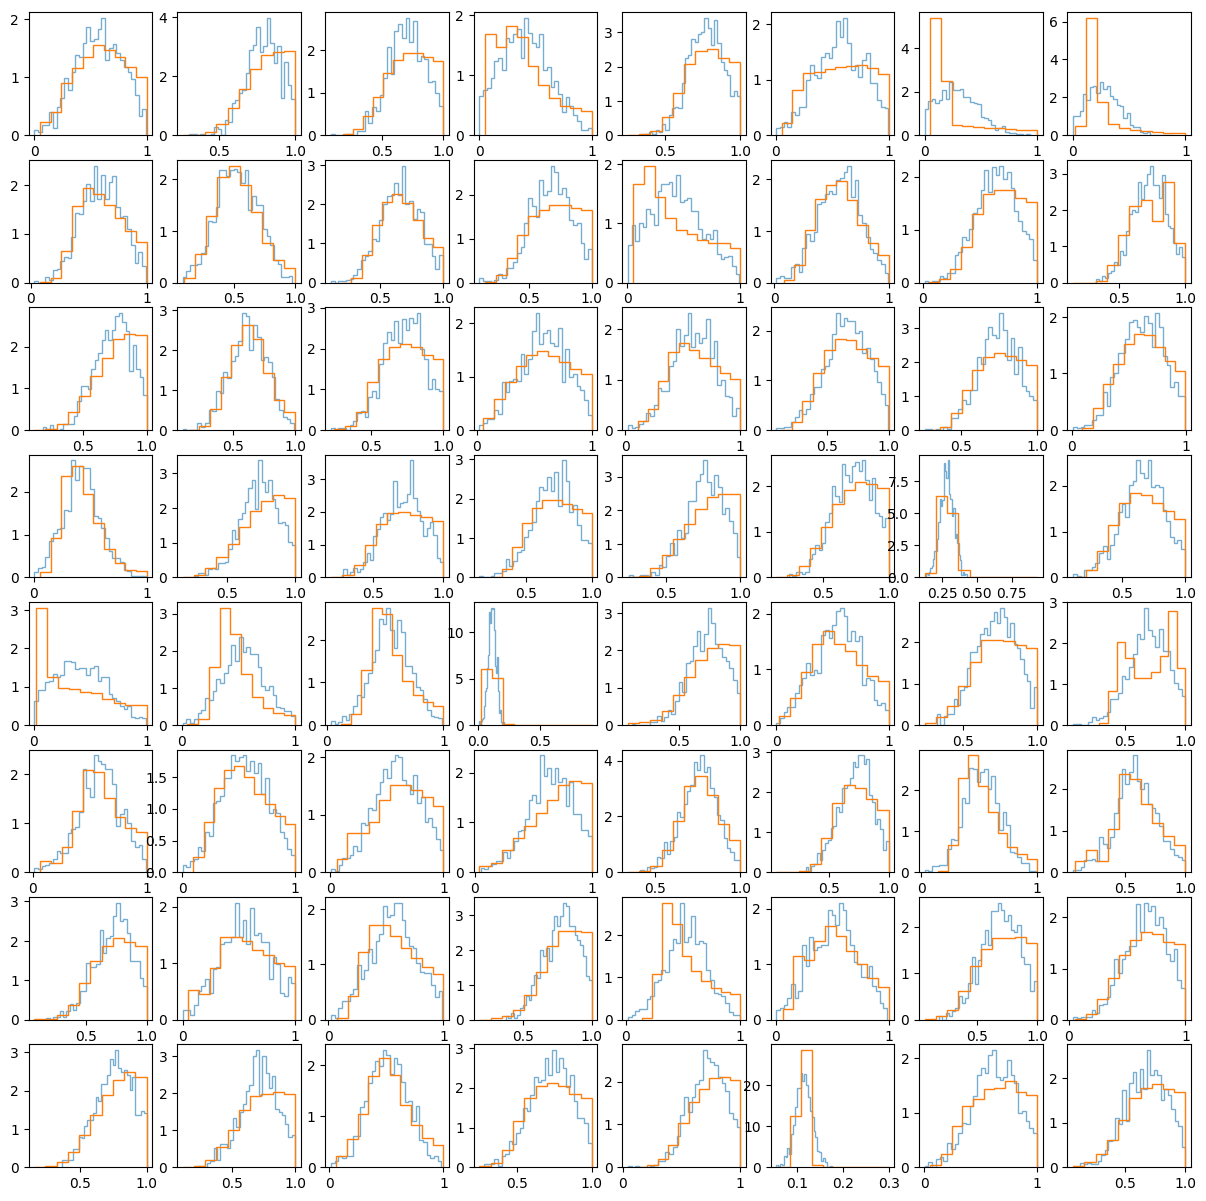

In [10]:
nrow = 8
ncol = 8
fig, ax = plt.subplots(nrow, ncol, figsize=(15,15))
for i in tqdm(range(nrow)):
    for j in range(ncol):
        idx = i * nrow + j
        # Parameters for the skew-normal distribution
        #alpha = alpha_fitted[idx]  # Shape parameter (controls skewness)
        alpha=-0.0066
        loc = x_max_fitted[idx]  # Location parameter (mean-like, center of the distribution)
        scale = sigma_fitted[idx]   # Shap   # Scale parameter (similar to standard deviation)

        # Generate truncated skew-normal samples
        samples = truncated_skewnorm(alpha, scale, loc, 0, 1, size=1000)
        # Plot the histogram of the samples
        ax[i,j].hist(samples, bins=30, density=True, alpha=0.6, color=colors[0], histtype='step')
        ax[i,j].hist(q[idx], histtype='step', density=True, label=str(np.median(q[idx]))+',snr='+str(np.median(snr[idx])), color=colors[1])
        #ax[i,j].legend()

Fitted proportionality constant (C): 1.7890483736761247


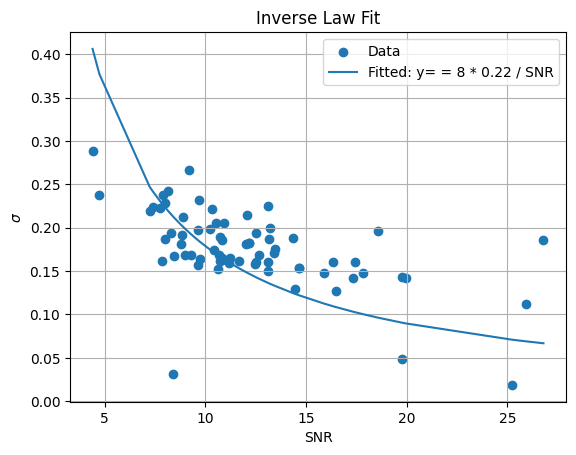

In [11]:
from scipy.optimize import curve_fit
# Define the inverse law model: y = C / x
def inverse_law(x, C):
    return C / x

# Perform curve fitting to find the proportionality constant C
popt, pcov = curve_fit(inverse_law, snr_median, sigma_fitted)

# Extract the proportionality constant
C_fitted = popt[0]

# Print the fitted proportionality constant
print(f"Fitted proportionality constant (C): {C_fitted}")

# Plot the original data and the fitted curve
plt.scatter(snr_median, sigma_fitted, label='Data')
plt.plot(np.sort(snr_median), inverse_law(np.sort(snr_median), C_fitted), label=f'Fitted: y= = 8 * {C_fitted/8:.2f} / SNR')
plt.ylabel(r'$\sigma$')
plt.xlabel('SNR')
plt.title('Inverse Law Fit')
plt.grid()
plt.legend()
plt.show()

100%|██████████| 8/8 [00:04<00:00,  1.88it/s]


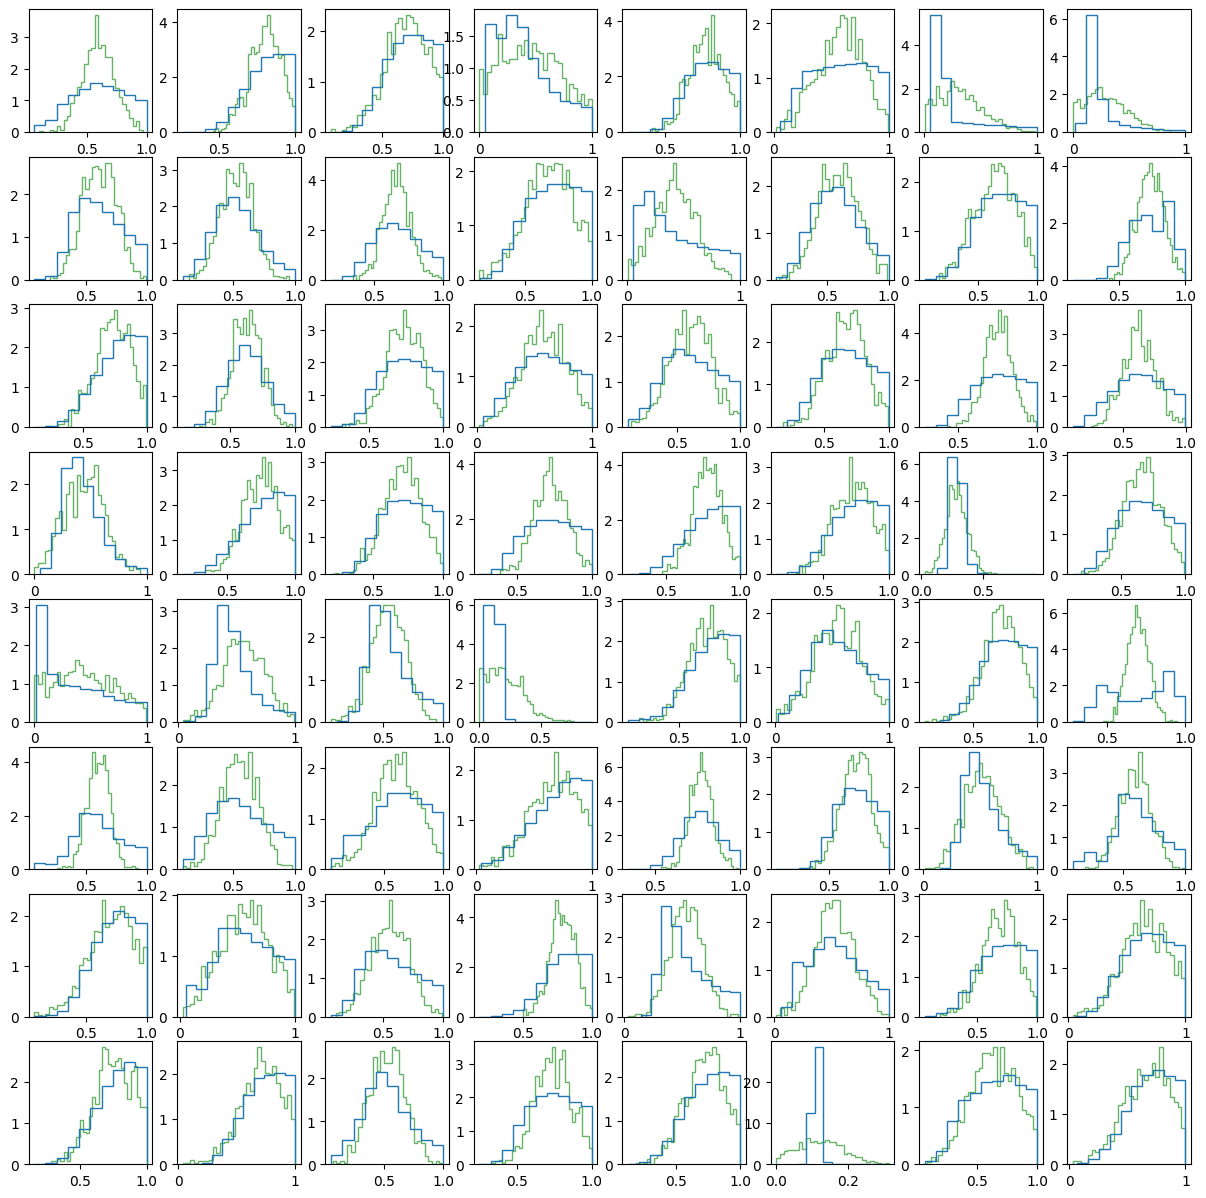

In [12]:
nrow = 8
ncol = 8
fig, ax = plt.subplots(nrow, ncol, figsize=(15,15))
for i in tqdm(range(nrow)):
    for j in range(ncol):
        idx = i * nrow + j
        # Parameters for the skew-normal distribution
        #alpha = alpha_fitted[idx]  # Shape parameter (controls skewness)
        alpha=-0.0066
        loc = x_max_fitted[idx]  # Location parameter (mean-like, center of the distribution)
        scale = 1.79/snr_median[idx]   # Shap   # Scale parameter (similar to standard deviation)

        # Generate truncated skew-normal samples
        samples = truncated_skewnorm(alpha, scale, loc, 0, 1, size=1000)
        # Plot the histogram of the samples
        ax[i,j].hist(samples, bins=30, density=True, alpha=0.6, color='g', histtype='step')
        ax[i,j].hist(q[idx], histtype='step', density=True, label=str(np.median(q[idx]))+',snr='+str(np.median(snr[idx])))
        #ax[i,j].set_title('Truncated Skew-Normal Distribution')
        #ax[i,j].legend()
        #plt.show()

In [13]:
snr_median = np.array([np.median(s) for s in snr])
q_median = np.array([np.median(qi) for qi in q])
mz_median = np.array([np.median(mi) for mi in mz])


In [14]:
np.median(alpha_fitted), np.mean(alpha_fitted)

(-0.006045049623289308, -0.006590393619936964)

# We can treat $\alpha$ as constant 

# Now we fit chirp mass with log normal

In [15]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize

# Sampling function: mz * exp(N(0, sigma)) where N(0, sigma) is a normal distribution
def custom_dist_sample(mz, sigma, size=1000):
    # Sample from a normal distribution with mean=0 and standard deviation=sigma
    normal_samples = np.random.normal(0, sigma, size)
    
    # Apply the scaling factor mz and the exponential
    samples = mz * np.exp(normal_samples)
    return samples

# Log-likelihood function for the given data and parameters
def log_likelihood(params, data):
    sigma = params  # Parameters: mz (scaling), sigma (std for normal)
    
    # Compute the PDF for each data point
    # First, we calculate the normal distribution part and then scale it
    normal_pdf = norm.pdf(np.log(data), 0, sigma)  # Normal distribution with mean=0
    
    # Avoid log(0) issues by adding a small epsilon to normal_pdf
    return -np.sum(np.log(normal_pdf + 1e-10))  # Minimize negative log-likelihood


# Example: Replace this with your actual data
mz_fitted, sigma_fitted = [], [] 
for i in range(mz.size):
    data = mz[i][:5000]/ np.median(mz[i][:5000])

    # Initial guesses for mz and sigma
    initial_params = [1.0]  # Initial guess: [mz, sigma]

    # Define bounds for the parameters
    bounds = [(1e-5, np.inf)]  # Example bounds for mz and sigma

    # Optimize the log-likelihood to find the best-fit parameters
    result = minimize(log_likelihood, initial_params, args=(data,), method='L-BFGS-B', bounds=bounds)

    # Extract the fitted parameters
    _sigma_fitted = result.x
    sigma_fitted.append(_sigma_fitted)


100%|██████████| 8/8 [00:00<00:00, 19.89it/s]


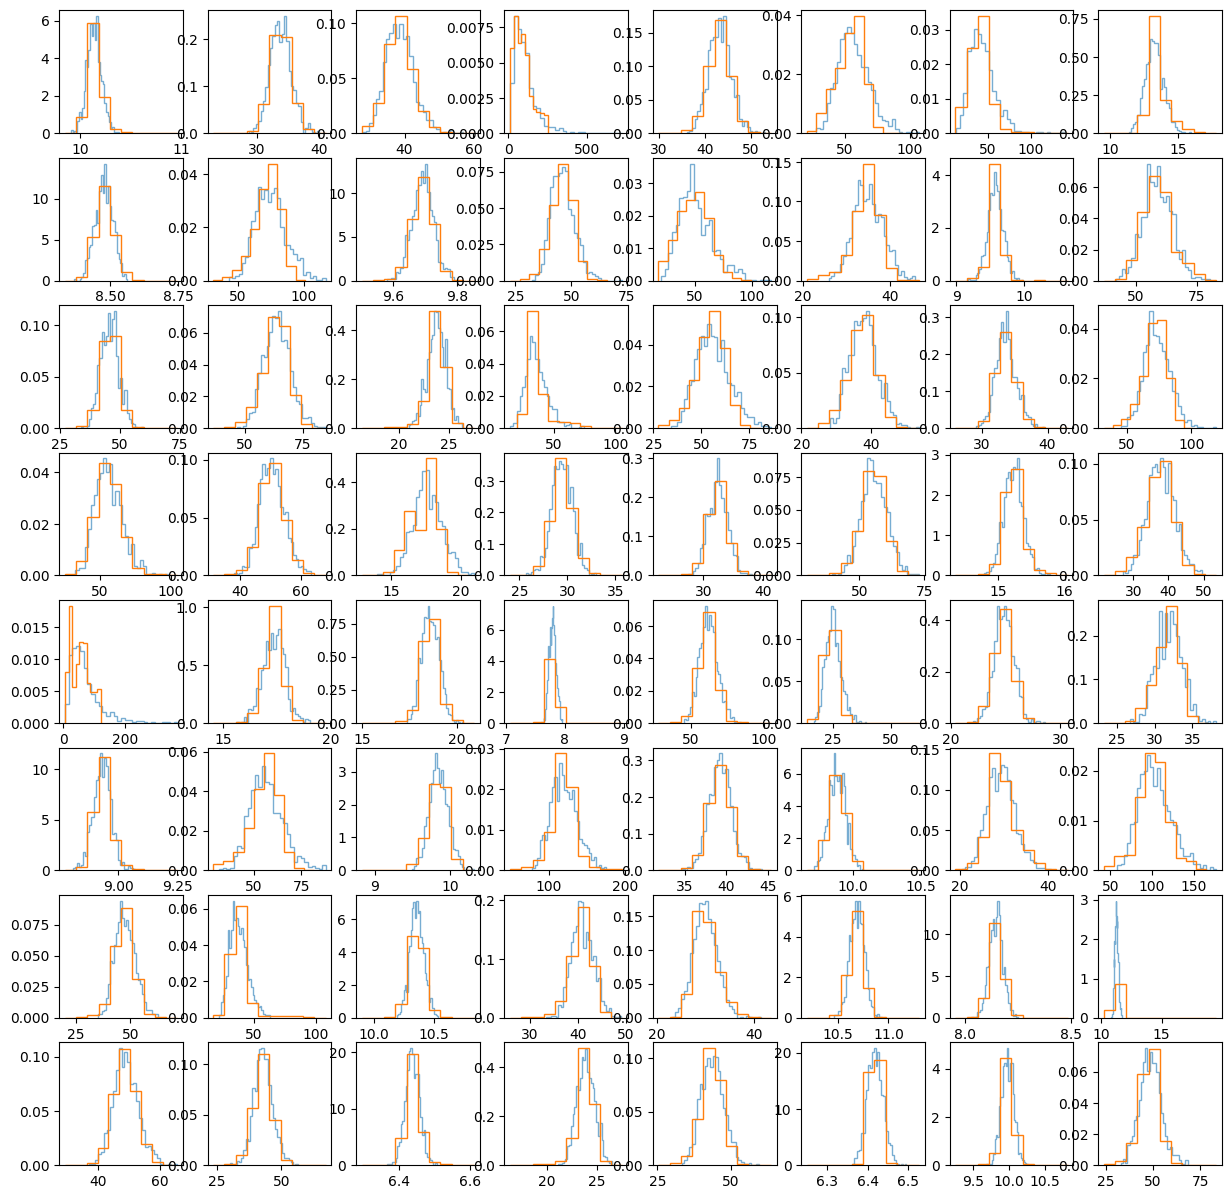

In [16]:
nrow = 8
ncol = 8

fig, ax = plt.subplots(nrow, ncol, figsize=(15,15))
for i in tqdm(range(nrow)):
    for j in range(ncol):
        idx = i * nrow + j
        # Parameters for the skew-normal distribution
        scale = sigma_fitted[idx]   #sigma

        # Generate truncated skew-normal samples
        samples = custom_dist_sample(mz_median[idx], scale, size=1000)
        # Plot the histogram of the samples
        ax[i,j].hist(samples, bins=30, density=True, alpha=0.6, color=colors[0], histtype='step')
        ax[i,j].hist(mz[idx], histtype='step', density=True, label=str(mz_median[idx])+',snr='+str(np.median(snr[idx])), color=colors[1])
        #ax[i,j].set_title('Truncated Skew-Normal Distribution')
        #ax[i,j].legend()
        #plt.show()

Fitted proportionality constant (C): 0.8584123683925845


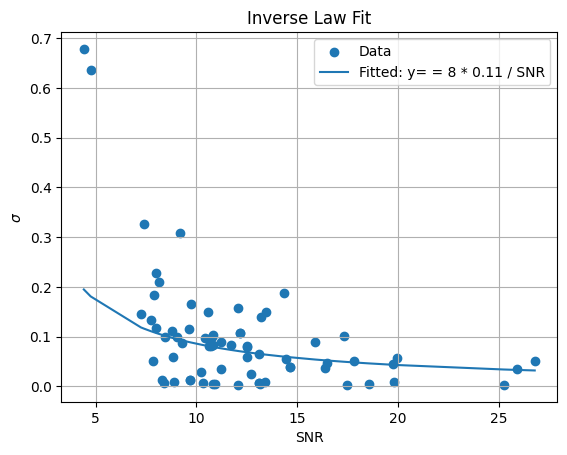

In [17]:
from scipy.optimize import curve_fit
# Define the inverse law model: y = C / x
def inverse_law(x, C):
    return C / x

# Perform curve fitting to find the proportionality constant C
popt, pcov = curve_fit(inverse_law, snr_median[snr_median>8], np.concatenate(sigma_fitted)[snr_median>8])

# Extract the proportionality constant
C_fitted = popt[0]

# Print the fitted proportionality constant
print(f"Fitted proportionality constant (C): {C_fitted}")

# Plot the original data and the fitted curve
plt.scatter(snr_median, sigma_fitted, label='Data')
plt.plot(np.sort(snr_median), inverse_law(np.sort(snr_median), C_fitted), label=f'Fitted: y= = 8 * {C_fitted/8:.2f} / SNR')
plt.ylabel(r'$\sigma$')
plt.xlabel('SNR')
plt.title('Inverse Law Fit')
plt.grid()
plt.legend()
plt.show()

100%|██████████| 8/8 [00:00<00:00, 19.13it/s]


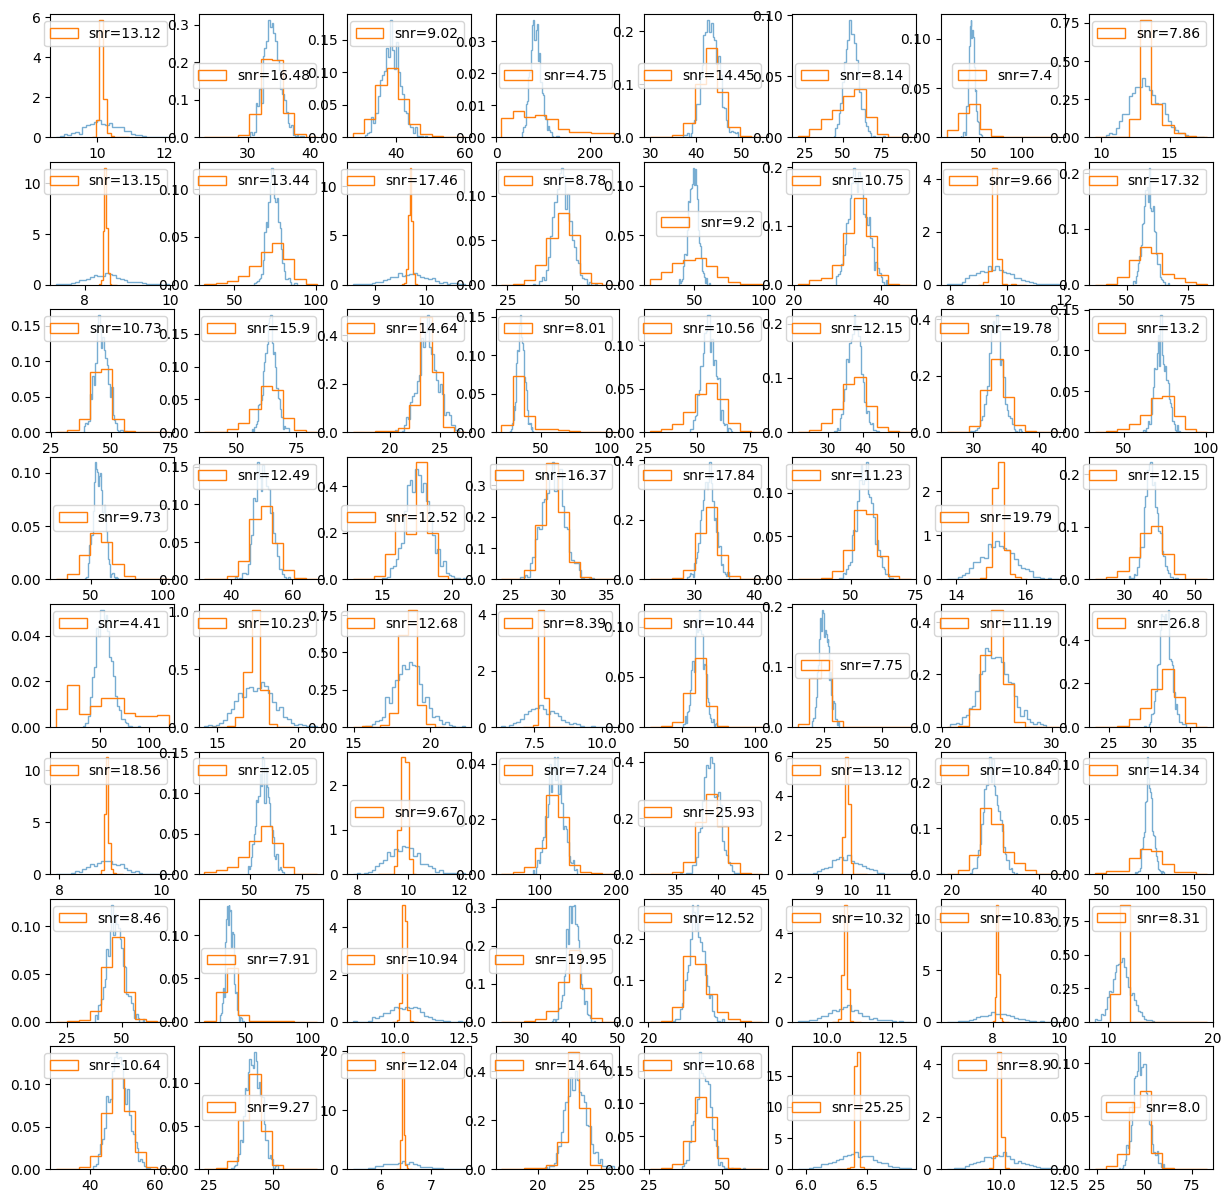

In [18]:
SNR_threshold  = 8
sigma_mass     = 0.08  * SNR_threshold

nrow = 8
ncol = 8
fig, ax = plt.subplots(nrow, ncol, figsize=(15,15))
for i in tqdm(range(nrow)):
    for j in range(ncol):
        idx = i * nrow + j 
        samples = mz_median[idx] * np.exp( np.random.normal(0, sigma_mass / snr_median[idx], 1000) )
        ax[i,j].hist(samples, bins=30, density=True, alpha=0.6, color=colors[0], histtype='step')
        ax[i,j].hist(mz[idx], histtype='step', density=True,label='snr='+str(round(snr_median[idx],2)), color=colors[1])
        ax[i,j].legend()

In [19]:
np.savez('./mz_fiited_params.npz', sigma=np.array(sigma_fitted))